In [191]:
import torch
import gpytorch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pygem
import pygem_input as pygem_prms
import pygem.pygem_modelsetup as modelsetup

In [201]:
class ExactGPModel(gpytorch.models.ExactGP):
    """ Use the simplest form of GP model, exact inference """
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [47]:
# ===== LOAD GLACIERS =====
glac_no = pygem_prms.glac_no
main_glac_rgi = modelsetup.selectglaciersrgitable(glac_no=glac_no)
glacier_rgi_table = main_glac_rgi.loc[main_glac_rgi.index.values[0], :]
glacier_str = '{0:0.5f}'.format(glacier_rgi_table['RGIId_float'])

em_mod_fn = glacier_str + f'-emulator-bin_thick_monthly.pth'
em_mod_fp = pygem_prms.emulator_fp + 'models/' + glacier_str.split('.')[0].zfill(2) + '/'

# ===== TIME PERIOD =====
dates_table = modelsetup.datesmodelrun(
        startyear=pygem_prms.ref_startyear, endyear=pygem_prms.ref_endyear, spinupyears=pygem_prms.ref_spinupyears,
        option_wateryear=pygem_prms.ref_wateryear)
print(dates_table)

1 glaciers in region 1 are included in this model run: ['22193']
This study is focusing on 1 glaciers in region [1]
               date  year  month  daysinmonth  wateryear  season
timestep                                                        
0        1990-01-01  1990      1           31       1990  winter
1        1990-02-01  1990      2           28       1990  winter
2        1990-03-01  1990      3           31       1990  winter
3        1990-04-01  1990      4           30       1990  winter
4        1990-05-01  1990      5           31       1990  summer
...             ...   ...    ...          ...        ...     ...
379      2021-08-01  2021      8           31       2021  summer
380      2021-09-01  2021      9           30       2021  summer
381      2021-10-01  2021     10           31       2022  winter
382      2021-11-01  2021     11           30       2022  winter
383      2021-12-01  2021     12           31       2022  winter

[384 rows x 6 columns]


In [235]:
# load emulator
torch.set_num_threads(1)

state_dict = torch.load(em_mod_fp + em_mod_fn)

emulator_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + emulator_extra_fn, 'rb') as f:
    emulator_extra_dict = pickle.load(f)

X_train = emulator_extra_dict['X_train']
X_mean = emulator_extra_dict['X_mean']
X_std = emulator_extra_dict['X_std']
y_train = emulator_extra_dict['y_train']
y_mean = emulator_extra_dict['y_mean']
y_std = emulator_extra_dict['y_std']
idx = np.argsort(y_train.numpy())

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create a new GP model
model = ExactGPModel(X_train, y_train, likelihood)  
# load model state after building emulator from training data
model.load_state_dict(state_dict)
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [236]:
lower,upper= likelihood(model(X_train)).confidence_region()
lower = lower.detach().numpy() * y_std + y_mean
upper = upper.detach().numpy() * y_std + y_mean

In [237]:
# evaluate model based on the data it was trained upon
y_train_em = model(X_train).mean.detach().numpy() * y_std + y_mean
y_train = y_train * y_std + y_mean

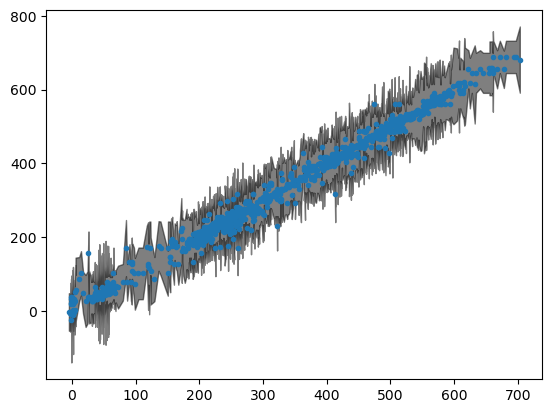

In [239]:
# plot
fig,ax=plt.subplots(1)
ax.fill_between(y_train[idx], lower[idx], upper[idx], color='k', alpha=.5)
ax.plot(y_train[idx], y_train_em[idx],'.')

In [55]:
modelprms = {}
modelprms['tbias'] = pygem_prms.tbias
modelprms['kp'] = pygem_prms.kp
modelprms['ddfsnow'] = pygem_prms.ddfsnow
modelprms['time'] = 10
modelprms['bin_h'] = 300
modelprms

{'tbias': 5, 'kp': 1, 'ddfsnow': 0.0041, 'time': 10, 'bin_h': 300}

In [119]:
modelprms_1d_norm = ((np.array([modelprms['tbias'], 
                                modelprms['kp'], 
                                modelprms['ddfsnow'], 
                               modelprms['time'], 
                               modelprms['bin_h']]) - 
                    X_mean) / X_std)    
print(modelprms_1d_norm,modelprms_1d_norm.shape)

[ 2.04967583 -0.60715591 -0.13376311 -2.57011307 -0.88487772] (5,)


In [143]:
np.array([[5,5,5,5,5],[5,5,5,5,5]]).shape

(2, 5)

In [145]:
modelprms_2d_norm.shape

(2, 5)

In [140]:
model(torch.tensor(np.array([[5,5,5,5,5],[5,5,5,5,5]]))).mean.detach().numpy()

array([-1.7182894, -1.7182894], dtype=float32)

In [147]:
modelprms_2d_norm = modelprms_1d_norm.reshape((1,5))
modelprms_2d_norm = np.tile(modelprms_1d_norm,(2,1))
print(modelprms_2d_norm)
bin_thick_norm = model(torch.tensor(modelprms_2d_norm).to(torch.float)).mean.detach().numpy()
print(bin_thick_norm)
bin_thick = bin_thick_norm * y_std + y_mean

[[ 2.04967583 -0.60715591 -0.13376311 -2.57011307 -0.88487772]
 [ 2.04967583 -0.60715591 -0.13376311 -2.57011307 -0.88487772]]
[-0.49058533 -0.49058533]


In [148]:
bin_thick

array([185.858, 185.858], dtype=float32)

In [181]:
# loop through all model time steps for 200-400 m and evaluate model
elev_range = np.arange(200,400,20)
time_steps = dates_table.index.values
time_steps = [5,10,100]
print(len(time_steps))

3


In [184]:
bin_thick = []
for t in time_steps:
    print(t)
    modelprms_2d_norm = ((np.array([np.repeat(modelprms['tbias'],len(elev_range)), 
                                    np.repeat(modelprms['kp'],len(elev_range)), 
                                    np.repeat(modelprms['ddfsnow'],len(elev_range)), 
                                    np.repeat(t,len(elev_range)), 
                                    elev_range]) -
                                    np.tile(X_mean.reshape(-1,1),(1,len(elev_range)))) / 
                                    np.tile(X_std.reshape(-1,1),(1,len(elev_range)))).T  
    
    bin_thick_norm = model(torch.tensor(modelprms_2d_norm).to(torch.float)).mean.detach().numpy()
    bin_thick.append(bin_thick_norm * y_std + y_mean)

5
10
100


In [182]:
len(bin_thick)

3

0
1
2


/var/folders/c2/td_159j56jb0xt8x35wytcw40000gn/T/ipykernel_40548/2259535232.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Color')


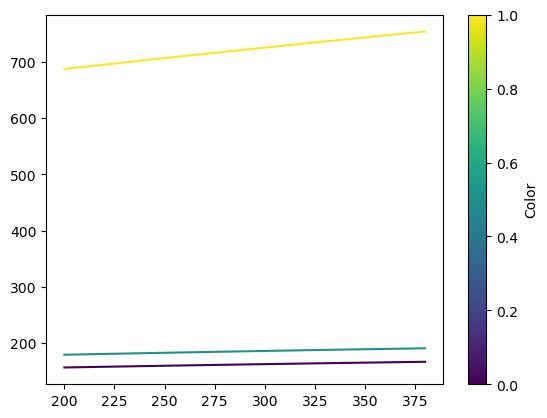

In [192]:
fig,ax = plt.subplots(1)
# Create a colormap instance
cmap = plt.get_cmap('viridis')
# Create a list of colors
colors = [cmap(i) for i in np.linspace(0, 1, len(time_steps))]
for t in range(len(time_steps)):
    print(t)
#     print(t)
    ax.plot(elev_range,bin_thick[t],c=colors[t])
    
# Create a ScalarMappable object
sm = ScalarMappable(cmap=cmap)
sm.set_array([])  # Empty array to ensure the full range of colormap is used

# Add colorbar
cbar = plt.colorbar(sm, label='Color')